In [2]:
import pandas as pd
import numpy as np
import sys, os
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
import pickle

if os.getcwd()[-4:] == "code":
    os.chdir('../')

icu = './data/mimic-iv-2.2-parquet/icu/'
hosp = './data/mimic-iv-2.2-parquet/hosp/'

In [2]:
d_items         = pd.read_parquet(icu+'d_items.parquet')
inputevents     = pd.read_parquet(icu+'inputevents.parquet')

In [3]:
d_antibiotics = d_items[(d_items['linksto']=='inputevents')&(d_items['category']=='Antibiotics')]
d_antibiotics = d_antibiotics[['itemid','label']]

inputevents_antibiotics = inputevents[inputevents['itemid'].isin(d_antibiotics.itemid.unique())]
inputevents_antibiotics['count'] = 1

count =inputevents_antibiotics.groupby(inputevents_antibiotics['itemid'])['count'].sum()

d_antibiotics = pd.merge(d_antibiotics,count,on='itemid',how='left')

C:\Users\DAHS\AppData\Local\Temp\ipykernel_65008\1990863507.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputevents_antibiotics['count'] = 1


In [4]:
d_antibiotics

,itemid,label,count
0,225798,Vancomycin,122649.0
1,225837,Acyclovir,9759.0
2,225838,Ambisome,770.0
3,225840,Amikacin,350.0
4,225842,Ampicillin,10076.0
5,225843,Ampicillin/Sulbactam (Unasyn),8065.0
6,225844,Atovaquone,134.0
7,225845,Azithromycin,4704.0
8,225847,Aztreonam,2978.0
9,225848,Caspofungin,317.0


In [5]:
inputevents['starttime'] = pd.to_datetime(inputevents['starttime'])

In [6]:
d_antibiotics.itemid.unique()

array([225798, 225837, 225838, 225840, 225842, 225843, 225844, 225845,
       225847, 225848, 225850, 225851, 225853, 225855, 225857, 225859,
       225860, 225862, 225863, 225865, 225866, 225868, 225869, 225871,
       225873, 225875, 225876, 225877, 225879, 225881, 225882, 225883,
       225884, 225885, 225886, 225888, 225889, 225890, 225892, 225893,
       225895, 225896, 225897, 225898, 225899, 225900, 225902, 225903,
       225905, 227691, 228003, 229059, 229061, 229064, 229587],
      dtype=int64)

In [7]:
inputevents['starttime'] = pd.to_datetime(inputevents['starttime'])

def ABduration(d_antibiotics,inputevents):
    itemid = d_antibiotics.itemid.unique()
    rt = []
    for i in tqdm(itemid):
        tmp = inputevents[inputevents['itemid']==i][['stay_id','starttime','itemid']]
        tmp.sort_values(by=['stay_id','starttime'],inplace=True)
        tmp.reset_index(inplace=True,drop=True)
        tmp = pd.concat([tmp.shift(1),tmp],axis=1)
        tmp.columns = ['stay_id_x','starttime_x','itemid_x','stay_id_y','starttime_y','itemid_y']
        
        tmp = tmp[tmp['stay_id_x'] == tmp['stay_id_y']]
        tmp['timediff'] = tmp['starttime_y'] - tmp['starttime_x']
        tmp['timediff_days'] = tmp.timediff.dt.total_seconds()/(60*60*24)
        timediff = [i,tmp.timediff_days.mean()*24]
        rt.append(timediff)

    rt = pd.DataFrame(rt)
    rt.columns = ['itemid','timediff']
    d_antibiotics = pd.merge(d_antibiotics,rt,on='itemid',how='left')
        
    return d_antibiotics

In [8]:
ABduration = ABduration(d_antibiotics,inputevents)

  0%|          | 0/55 [00:00<?, ?it/s]

In [9]:
ABduration.sort_values(by='count',ascending=False, inplace=True)
ABduration.reset_index(inplace=True,drop=True)
ABduration

,itemid,label,count,timediff
0,225798,Vancomycin,122649.0,17.535464
1,225851,Cefepime,61582.0,15.178661
2,225893,Piperacillin/Tazobactam (Zosyn),60647.0,9.738373
3,225884,Metronidazole,56718.0,10.112477
4,225850,Cefazolin,38994.0,10.641793
5,225883,Meropenem,38172.0,10.488165
6,225855,Ceftriaxone,17725.0,25.431679
7,225859,Ciprofloxacin,17278.0,17.215766
8,225888,Nafcillin,11532.0,5.003673
9,225892,Piperacillin,10892.0,12.837419


In [10]:
ABduration.to_csv('./data/ABduration.csv')

In [12]:
ABduration = pd.read_csv('./data/ABduration.csv')

In [15]:
AB_category = ABduration.category.unique()

In [19]:
ABduration[ABduration['category']==AB_category[0]].itemid

0     225898
1     225877
2     225895
3     225868
4     225869
5     225885
6     225905
7     225838
8     225848
9     225844
10    225896
11    225837
12    225873
13    228003
14    225871
15    225903
Name: itemid, dtype: int64

In [43]:
def ABduration2(AB_duration,inputevents):
    category = AB_duration.category.unique()
    rt = []
    for i in tqdm(category):
        itemid = ABduration[ABduration['category']==i].itemid
        tmp = inputevents[inputevents['itemid'].isin(itemid)][['stay_id','starttime','itemid']]
        tmp.sort_values(by=['stay_id','starttime'],inplace=True)
        tmp.reset_index(inplace=True,drop=True)
        tmp = pd.concat([tmp.shift(1),tmp],axis=1)
        tmp.columns = ['stay_id_x','starttime_x','itemid_x','stay_id_y','starttime_y','itemid_y']
        
        tmp = tmp[tmp['stay_id_x'] == tmp['stay_id_y']]
        tmp['timediff'] = tmp['starttime_y'] - tmp['starttime_x']
        tmp['timediff_days'] = tmp.timediff.dt.total_seconds()/(60*60*24)
        tmp = tmp[tmp['timediff_days']<24]
        timediff = [i,tmp.timediff_days.mean()*24]
        rt.append(timediff)

    rt = pd.DataFrame(rt)        
    return rt

In [44]:
rt2 = ABduration2(ABduration,inputevents)

  0%|          | 0/16 [00:00<?, ?it/s]

In [45]:
rt2.columns = ['itemid','count']

In [ ]:
rt2.sort_index()

In [46]:
rt2.sort_values("itemid",ascending=True)

,itemid,count
7,Aminoglycosides,24.305506
0,Anti,18.332528
8,Beta-lactam-comb,9.416163
1,Carbapenems,10.234564
2,Cephalosporins,14.942264
3,Fluoroquinolones,19.933517
10,Lincosamides,8.726084
12,Linezolid,14.828397
11,Macrolides,23.606006
4,Metronidazole,9.907401


In [34]:
ABduration

,Unnamed: 0,itemid,ATC code,depth_1,depth_2,depth_3,category,count,label,timediff
0,32,225898,J04AB02,Antimycobacterials,NaN,NaN,Anti,402,Rifampin,24.32
1,46,225877,J04AC01,Antimycobacterials,NaN,NaN,Anti,15,Isoniazid,180.44
2,47,225895,J04AK01,Antimycobacterials,NaN,NaN,Anti,14,Pyrazinamide,105.49
3,48,225868,J04AK02,Antimycobacterials,NaN,NaN,Anti,13,Ethambutol,148.03
4,17,225869,J02AC01,Antimycotics,NaN,NaN,Anti,4712,Fluconazole,30.09
5,19,225885,J02AX05,Antimycotics,NaN,NaN,Anti,4677,Micafungin,31.26
6,25,225905,J02AC03,Antimycotics,NaN,NaN,Anti,1714,Voriconazole,18.04
7,30,225838,J02AA01,Antimycotics,NaN,NaN,Anti,770,Ambisome,28.68
8,36,225848,J02AX04,Antimycotics,NaN,NaN,Anti,317,Caspofungin,26.68
9,40,225844,P01AX06,Antiprotozoals,NaN,NaN,Anti,134,Atovaquone,40.59


In [79]:
tmp = inputevents[inputevents['itemid'].isin([225798])].sort_values(['stay_id','starttime'])[['stay_id','starttime']]
tmp = pd.concat([tmp,tmp.shift(1)],axis=1)

In [80]:
tmp.columns = ['stay_id_x','charttime_x','stay_id_y','charttime_y']
tmp = tmp[tmp['stay_id_x'] == tmp['stay_id_y']]
tmp['timediff'] = tmp['charttime_x'] - tmp['charttime_y']
tmp['timediff_days'] = tmp.timediff.dt.total_seconds()/(60*60)

In [81]:
tmp = tmp[tmp['timediff_days'] <= 72]

Text(0.5, 0, 'hours')

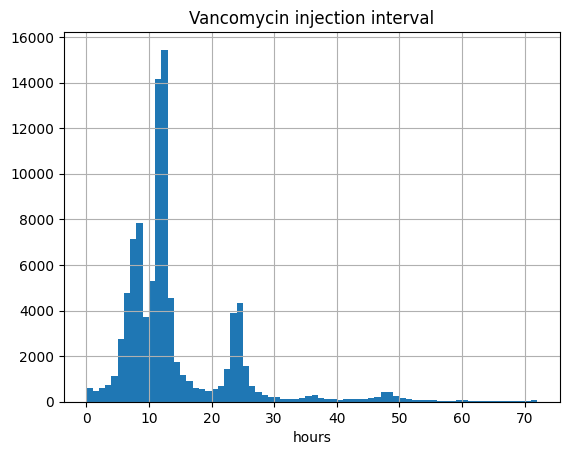

In [86]:
tmp.timediff_days.hist(bins=72)
plt.title("Vancomycin injection interval")
plt.xlabel("hours")

In [3]:
vitalsign = pd.read_parquet('./data/mimic-iv-2.2-parquet/ed/vitalsign.parquet')

In [5]:
d_labitems    = pd.read_parquet(hosp+'d_labitems.parquet')

In [8]:
vitalsign['temperature']

0           NaN
1           NaN
2           NaN
3           NaN
4          98.4
           ... 
1564605    98.1
1564606    99.5
1564607     NaN
1564608     NaN
1564609    99.3
Name: temperature, Length: 1564610, dtype: float64